In [4]:
import pandas as pd

# Load the data
df = pd.read_parquet("../data/ingested/cricket_data.parquet")

# 1. How big is it really?
print(f"Total Deliveries: {len(df):,}")
print(f"Total Matches: {df['match_id'].nunique()}")

# 2. Check the columns and data types
print(df.info())


Total Deliveries: 1,683,590
Total Matches: 872
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683590 entries, 0 to 1683589
Data columns (total 54 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   match_id            1683590 non-null  object 
 1   data_version        1683590 non-null  object 
 2   season              1683590 non-null  object 
 3   dates               1683590 non-null  object 
 4   start_date          1683590 non-null  object 
 5   city                1479044 non-null  object 
 6   venue               1683590 non-null  object 
 7   balls_per_over      1683590 non-null  int64  
 8   event_name          1667107 non-null  object 
 9   event_match_number  1641355 non-null  float64
 10  gender              1683590 non-null  object 
 11  match_type          1683590 non-null  object 
 12  match_type_number   1683590 non-null  int64  
 13  team_type           1683590 non-null  object 
 14  team_a             

In [6]:
# Check for null values
print("Missing values per column:")
print(df.isnull().sum())

# If this is 0, your ingestion logic might have missed a field
print(f"Average runs per ball: {df['runs_total'].mean():.2f}")

Missing values per column:
match_id                    0
data_version                0
season                      0
dates                       0
start_date                  0
city                   204546
venue                       0
balls_per_over              0
event_name              16483
event_match_number      42235
gender                      0
match_type                  0
match_type_number           0
team_type                   0
team_a                      0
team_b                      0
toss_winner                 0
toss_decision               0
outcome_winner         362666
outcome_by_wickets    1274247
player_of_match         11039
umpire_1                    0
umpire_2                    0
tv_umpire                   0
match_referee               0
innings_num                 0
batting_team                0
bowling_team                0
over                        0
ball                        0
batter                      0
bowler                      0
non_striker  

In [7]:
# 1. Matches per Season (missing any years?)
print("Matches per Season:")
print(df.groupby('season')['match_id'].nunique().sort_index(ascending=False))

# 2. Dismissal Types (most common?)
print("\nDismissal Breakdown:")
print(df[df['is_wicket'] == 1]['dismissal_kind'].value_counts())

# 3. Innings check (Do we have 1st, 2nd, 3rd, and 4th innings?)
print("\nDeliveries per Innings:")
print(df['innings_num'].value_counts())

Matches per Season:
season
2025/26    15
2025       18
2024/25    29
2024       13
2023/24    20
2023       13
2022/23    25
2022       15
2021/22    28
2021       16
2020/21    22
2020        6
2019/20    24
2019       10
2018/19    32
2018       15
2017/18    28
2017       16
2016/17    38
2016       18
2015/16    23
2015       23
2014/15    17
2014       17
2013/14    26
2013       11
2012/13    30
2012       13
2011/12    34
2011       17
2010/11    20
2010       14
2009/10    25
2009       14
2008/09    28
2008       13
2007/08    31
2007       12
2006/07    14
2006       13
2005/06    22
2005        8
2004/05    15
2004        2
2003/04    17
2003        7
2002/03     4
2001/02     1
Name: match_id, dtype: int64

Dismissal Breakdown:
dismissal_kind
caught                   16587
bowled                    4890
lbw                       4628
run out                    742
caught and bowled          604
stumped                    502
retired hurt                45
hit wicket        

In [8]:
# Top 5 Run Scorers
top_batters = df.groupby('batter')['runs_batter'].sum().sort_values(ascending=False).head(5)
print("Top 5 Run Scorers in Dataset:")
print(top_batters)

# Top 5 Wicket Takers
# Filter for wickets that count toward a bowler's stats (exclude run outs)
bowler_wickets = ['bowled', 'caught', 'lbw', 'stumped', 'caught and bowled', 'hit wicket']
top_bowlers = df[df['dismissal_kind'].isin(bowler_wickets)].groupby('bowler').size().sort_values(ascending=False).head(5)
print("\nTop 5 Wicket Takers in Dataset:")
print(top_bowlers)

Top 5 Run Scorers in Dataset:
batter
JE Root          13777
AN Cook          12472
SPD Smith        10613
KS Williamson     9461
V Kohli           9230
Name: runs_batter, dtype: int64

Top 5 Wicket Takers in Dataset:
bowler
JM Anderson    682
SCJ Broad      604
NM Lyon        567
R Ashwin       532
DW Steyn       431
dtype: int64


In [9]:
sachin_stats = df[df['batter'] == 'SR Tendulkar']
print(f"First recorded ball for Sachin: {sachin_stats['season'].min()}")
print(f"Last recorded ball for Sachin: {sachin_stats['season'].max()}")
print(f"Total runs in this dataset: {sachin_stats['runs_batter'].sum()}")

First recorded ball for Sachin: 2001/02
Last recorded ball for Sachin: 2013/14
Total runs in this dataset: 6416


In [14]:

# datetime conversion
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')

# 2. Check for failures (any dates that couldn't be parsed will be NaT)
if df['start_date'].isna().any():
    print(f"Warning: {df['start_date'].isna().sum()} rows have invalid dates!")

# 3. Now you can create your year column
df['year'] = df['start_date'].dt.year


# Count deliveries per year
balls_per_year = df.groupby(df['year']).size()

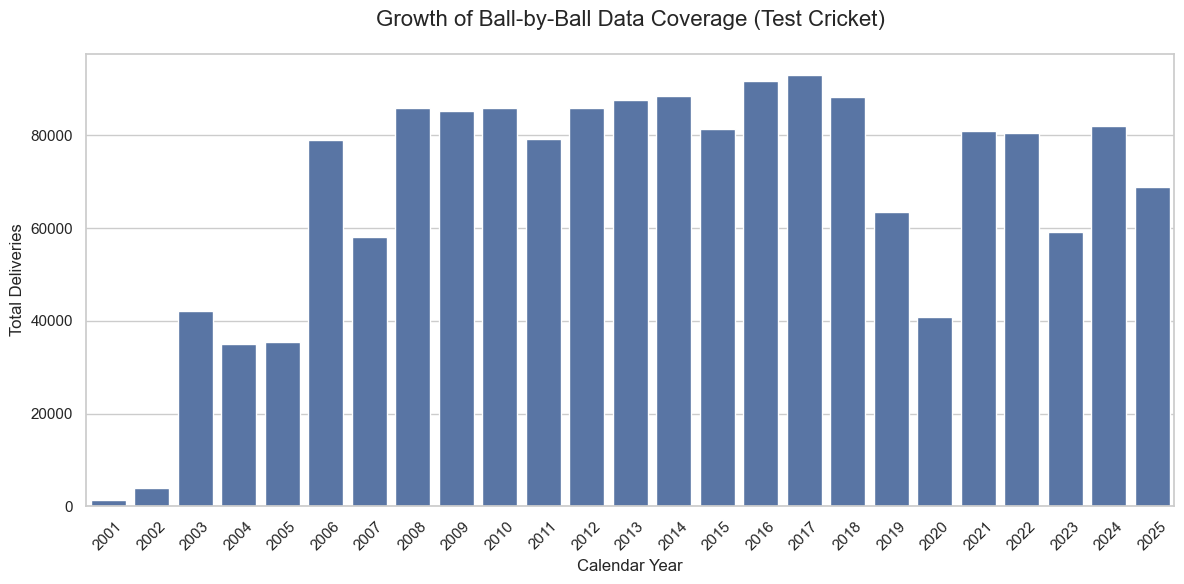

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Set a professional theme (darkgrid, whitegrid, or ticks)
sns.set_theme(style="whitegrid")

# 2. Prepare the data (convert Series to DataFrame)
df_plot = balls_per_year.reset_index()
df_plot.columns = ['Year', 'Delivery_Count']

# 3. Create the plot
plt.figure(figsize=(12, 6))
plot = sns.barplot(
    data=df_plot, 
    x='Year', 
    y='Delivery_Count', 
    legend=False
)

# 4. Final Polish
plt.title("Growth of Ball-by-Ball Data Coverage (Test Cricket)", fontsize=16, pad=20)
plt.xlabel("Calendar Year", fontsize=12)
plt.ylabel("Total Deliveries", fontsize=12)

# Rotate labels so they don't overlap
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()